![Mars Panorama](mars.jpg)

# RedRank

#### A Bayesian Terraforming Mars player rating system using Microsoft TrueSkill

#### Kevin Beam

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

The game results for all games to date. This will be loaded dynamically from a Google Sheet in the future, but for now are recorded below.

In [2]:
game_data = [
    {'Steve': 121, 'Benjamin': 109.5, 'Todd': 98},
    {'Steve': 82, 'Matt': 70, 'Allis': 64, 'Todd': 61, 'Benjamin': 59},
    {'Todd': 80, 'Matt': 78, 'Benjamin': 74, 'Steve': 71},
    {'Todd': 74, 'Matt': 71, 'Allis': 71, 'Benjamin': 62, 'Steve': 48},
    {'Allis': 96, 'Benjamin': 93, 'Steve': 87},
    {'Allis': 99, 'Benjamin': 92, 'Steve': 92},
    {'Steve': 159, 'Todd': 130},
    {'Matt': 78, 'Todd': 64, 'Benjamin': 62, 'Steve': 60, 'Kevin': 48},
    {'Allis': 145, 'Todd': 115}
]

games = pd.DataFrame(game_data)
games.fillna('-')

,Allis,Benjamin,Kevin,Matt,Steve,Todd
0,-,109.5,-,-,121,98
1,64,59,-,70,82,61
2,-,74,-,78,71,80
3,71,62,-,71,48,74
4,96,93,-,-,87,-
5,99,92,-,-,92,-
6,-,-,-,-,159,130
7,-,62,48,78,60,64
8,145,-,-,-,-,115


---

# TrueSkill

#### Use Microsoft TrueSkill to rate the players

---

In [3]:
import math
from functools import partial
from scipy.stats import norm
import seaborn as sns; sns.set()
from trueskill import global_env, quality_1vs1, rate, setup, Rating, BETA
setup(backend='scipy')

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=10.0%, backend='scipy')

In [4]:
ratings = {n: Rating() for n in games.columns}

In [5]:
def update_ratings(ratings, game):
    game = game.dropna()
    rating_groups = [(ratings[n],) for n in game.index]
    ranks = game.rank(ascending=False).values.astype(int)
    new_ratings = rate(rating_groups, ranks)
    for n, nr in zip(game.index, new_ratings):
        ratings[n] = nr[0]
        
games.apply(partial(update_ratings, ratings), axis='columns')

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
dtype: object

## TrueSkill ratings after all games

In [6]:
ratings

{'Allis': trueskill.Rating(mu=29.182, sigma=3.054),
 'Benjamin': trueskill.Rating(mu=21.708, sigma=2.388),
 'Kevin': trueskill.Rating(mu=15.136, sigma=5.569),
 'Matt': trueskill.Rating(mu=29.153, sigma=2.968),
 'Steve': trueskill.Rating(mu=21.022, sigma=2.431),
 'Todd': trueskill.Rating(mu=25.560, sigma=2.605)}

## Conservative estimate of player strength -- there is a 99% chance your rating is above this level

In [7]:
for n, r in ratings.items():
    print('{}: {:.4}'.format(n, r.mu - 3*r.sigma))

Allis: 20.02
Benjamin: 14.54
Kevin: -1.571
Matt: 20.25
Steve: 13.73
Todd: 17.74


## Player rating estimate curves
### Location of the peak indicates mean player strength estimate, width of curve is the estimate uncertainty

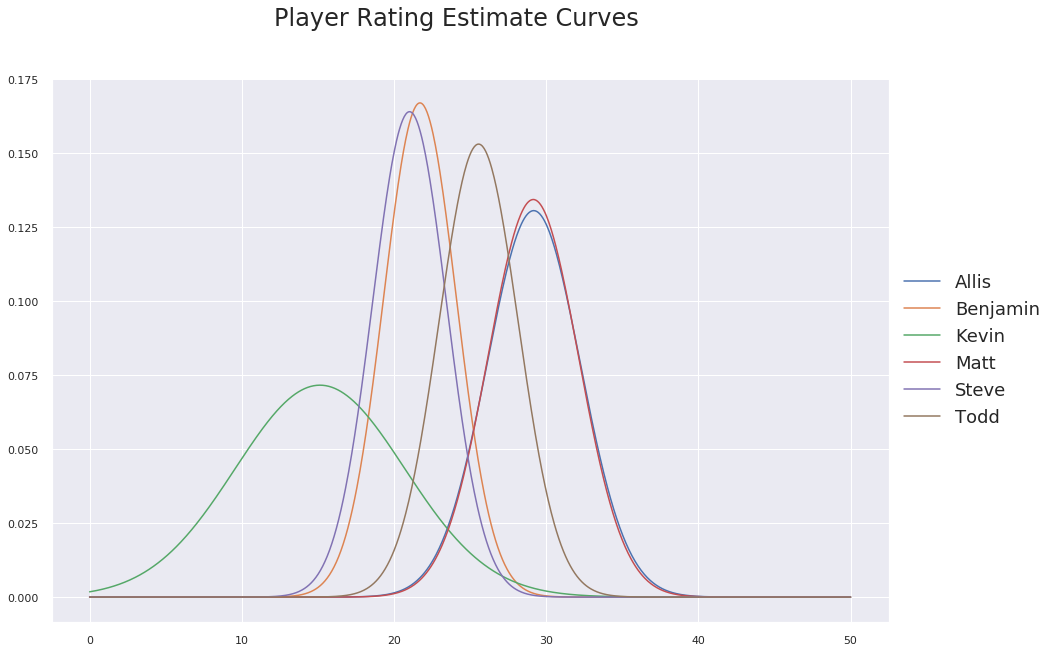

In [8]:
f = plt.figure(figsize=(15,10))
f.suptitle('Player Rating Estimate Curves', fontsize=24)
x = np.linspace(0,50,1000)
for n, r in ratings.items():
    plt.plot(x, norm.pdf(x, loc=r.mu, scale=r.sigma), label=n)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=18)

## Pairwise expected match results based on player rating, which includes rating uncertainty

In [9]:
def win_prob(p1, p2):
    delta_mu = p1.mu - p2.mu
    sum_sigma = p1.sigma ** 2 + p2.sigma ** 2
    return global_env().cdf(delta_mu / math.sqrt(2*BETA*BETA + sum_sigma))
        
wp = {n: [100*win_prob(ratings[o], ratings[n]) for o in games.columns] 
      for n in games.columns}
wp_df = pd.DataFrame(wp, index=games.columns)
wp_df

,Allis,Benjamin,Kevin,Matt,Steve,Todd
Allis,50.000000,85.536408,94.752382,50.158047,87.586246,69.429676
Benjamin,14.463592,50.000000,78.158173,14.431429,54.013107,28.752536
Kevin,5.247618,21.841827,50.000000,5.223587,24.340878,11.046586
Matt,49.841953,85.568571,94.776413,50.000000,87.624960,69.378077
Steve,12.413754,45.986893,75.659122,12.375040,50.000000,25.494799
Todd,30.570324,71.247464,88.953414,30.621923,74.505201,50.000000


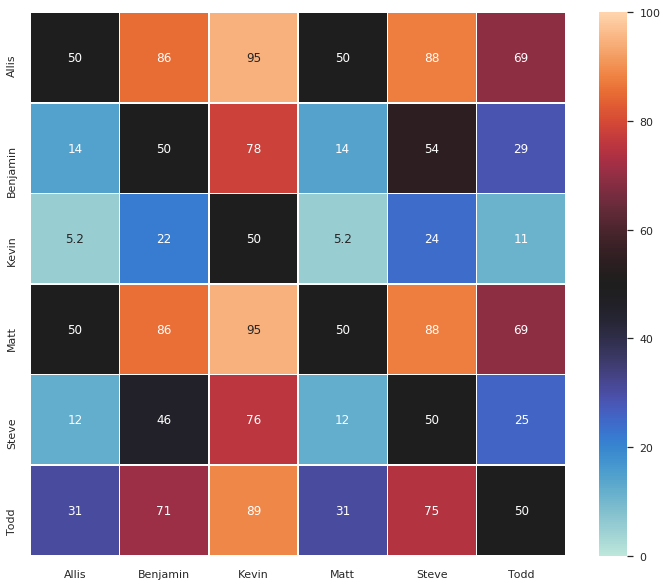

In [11]:
plt.subplots(figsize=(12,10))
sns.heatmap(wp_df, vmin=0, vmax=100, center=50, annot=True, linewidths=0.5)